# Introduction

This is a *binary classification* problem in which the aim is to predict which patients have diabetes based on a number of measurements. 

The focus of this notebook is on the *binary classification metrics*, including confusion matrix, multiple kinds of scores (accuracy, precision, recall and F1 score), ROC curve and AUC.  

There are substantial fraction of missing data that needed to be handled. These data is indicated by examples with value 0 of Glucose, BloodPressure, BMI and Insulin. Instead of removing these examples, we created dummy variables to indicate whether of not these other variables have valid values. Apart from that, no other feature engineering step was required.

A simple modeling using Logistic Regression and Random Forest is performed, without any kind of optimization.

Dataset details can be found [here](https://www.kaggle.com/uciml/pima-indians-diabetes-database).

**This notebook is part of my learning process, therefore any feedback is welcome and appreciated =)**

# Data Exploration and Preparation

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
# Setting plt and sns styles
plt.style.use('seaborn-dark')
sns.set(style='dark')

In [4]:
# Ignoring warnings
import warnings
warnings.filterwarnings('ignore')

In [5]:
# Reading data
data = pd.read_csv('../data/diabetes.csv')

In [6]:
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [7]:
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [8]:
# Checking for missing data as NaN entries
data.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [9]:
features = list(data.columns)
features.remove('Outcome')

In [10]:
# Calculating the relative size of each class
N_TRUE = len(data[data['Outcome'] == 1])
N_FALSE = len(data) - N_TRUE

print('N_TRUE = {}'.format(N_TRUE))
print('N_FALSE = {}'.format(N_FALSE))
print('N_FALSE fraction = {:.3f}'.format(N_FALSE/(N_FALSE+N_TRUE)))

N_TRUE = 268
N_FALSE = 500
N_FALSE fraction = 0.651


## Variables - Summary

- 8 numerical features: Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DiabetesPedigreeFunction, Age.
- There is no NaN entry in the dataset.
- No feature engineering seems to be necessary.
- Outcome is the target variable (0 or 1).
- 65% of the examples do not have diabetes, which will be our baseline for accuracy score of the classifiers.  

## Distributions and Correlations

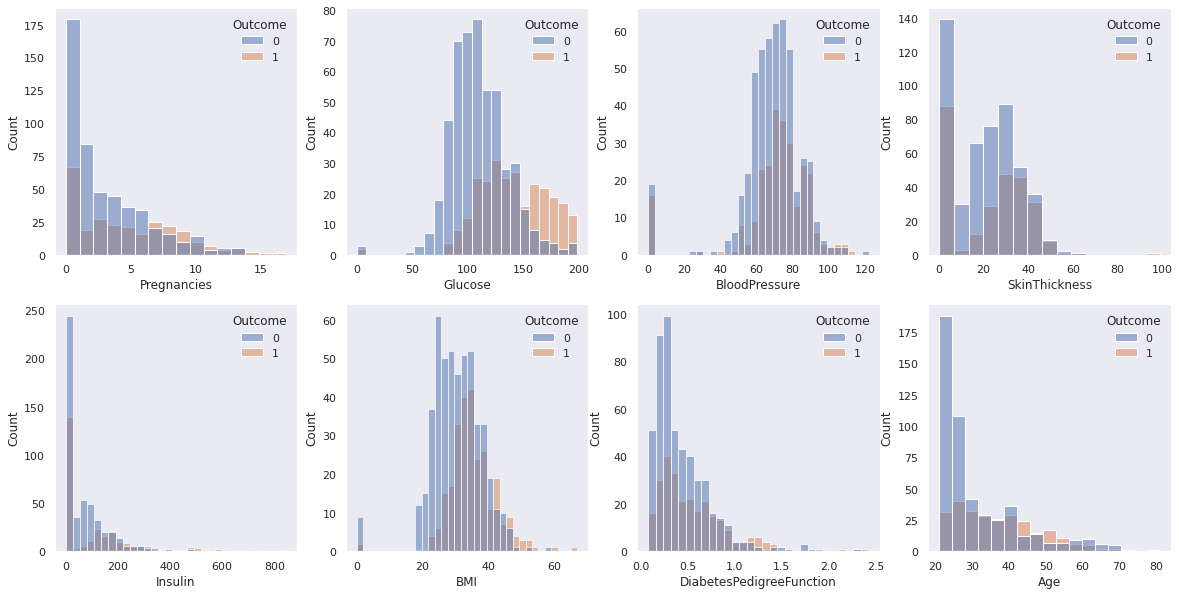

In [11]:
# Plotting distributions of features split by target
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
axs = axs.flatten()

for ax, feat in zip(axs, features):
    sns.histplot(data, x=feat, hue='Outcome', ax=ax);

- The feature distributions look all fine in general (nearly gaussian shape, no outliers)
- There are spikes at 0 in a number of features (Glucose, BloodPressure, BMI and Insulin). We know that these measurements should never be zero, so these must be examples in which these **measurements are missing**. We are going to clean these examples next.

## Handling Missing Data

In [12]:
# Counting examples with value 0 of Glucose, BloodPressure, BMI or Insulin.
data_with_zeros = data[
    (data['Glucose'] == 0)
    | (data['BMI'] == 0)
    | (data['Insulin'] == 0)
    | (data['BloodPressure'] == 0)
]
print('N of examples with incomplete data = {}'.format(len(data_with_zeros)))

N of examples with incomplete data = 376


- The number of incomplete examples is too large to be simply removed. Instead we will created new dummy variables to indicate whether of not a certain features is valid. 

In [13]:
# Creating dummy variables to indicate whether Glucose, BloodPressure, BMI and Insulin data is valid.
for feat in ['Glucose', 'BloodPressure', 'BMI', 'Insulin']:
    new_feat = 'Valid' + feat
    data[new_feat] = data[feat].map(lambda d: int(d != 0))
    features.append(new_feat)
print(features)

['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'ValidGlucose', 'ValidBloodPressure', 'ValidBMI', 'ValidInsulin']


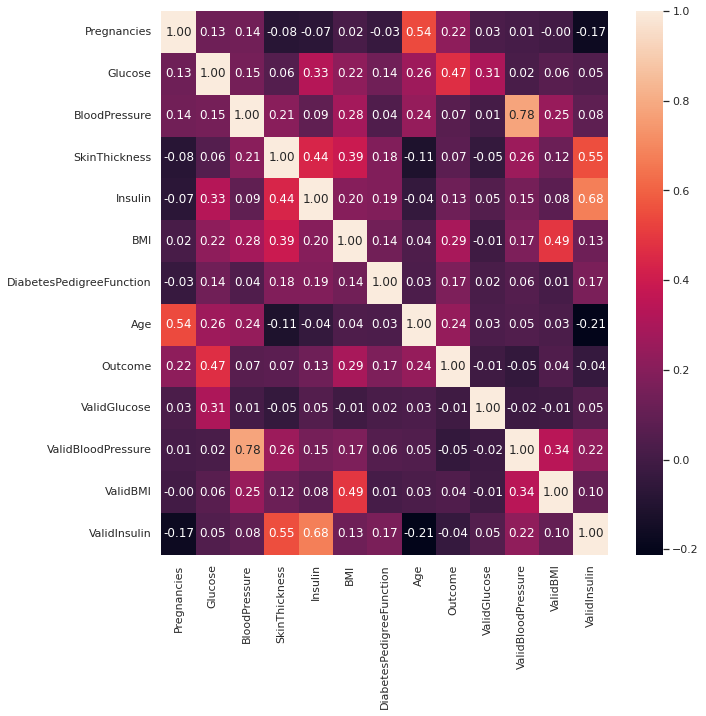

In [14]:
# Looking at the correlations
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(data.corr(), annot=True, fmt='.2f', ax=ax);

## Rescaling

In [15]:
# Standard scaling
from sklearn.preprocessing import StandardScaler

In [16]:
# Preparing X and y arrays 
X_train, y_train = data[features].to_numpy(), data['Outcome'].to_numpy()

In [17]:
scaler = StandardScaler().fit(X_train)
X_train_std = scaler.transform(X_train)

# Modeling

A simple modeling will be performed, using only Logistic Regression and Random Forest classifiers.

The dataset is small (< 1000 examples) and the number of features not large (20), so computing performance should not be an issue.

We will use *cross validation* to evaluate the classifiers. All the metrics will be calculated using the validation datasets. Since this is only a simple analysis for learning purposes, we will not separate a test sample for a final evaluation. 

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import KFold

In [34]:
# Building and fitting models using KFold with 5 splits.
# The classifiers are LogisticRegression, RandomForestClassifier and DummyClassifier

from collections import defaultdict

kf = KFold(n_splits=5)
results = dict()
results['LogisticRegression'] = defaultdict(list)
results['RandomForest'] = defaultdict(list)
results['DummyClassifier'] = defaultdict(list)

for train_index, test_index in kf.split(X_train_std):
    X_train_cv, X_val_cv = X_train_std[train_index], X_train_std[test_index]
    y_train_cv, y_val_cv = y_train[train_index], y_train[test_index]
    
    # print('Fitting LogReg {}'.format(counter))
    for key in results.keys():
        if key == 'LogisticRegression':
            clf = LogisticRegression(C=1).fit(X_train_cv, y_train_cv)
        elif key == 'RandomForest':
            clf = RandomForestClassifier(n_estimators=100).fit(X_train_cv, y_train_cv)
        else:
            clf = DummyClassifier(strategy='most_frequent').fit(X_train_cv, y_train_cv)
    
        results[key]['pred'].append(clf.predict(X_val_cv))
        results[key]['prob'].append(clf.predict_proba(X_val_cv))
        results[key]['true'].append(y_val_cv)
        results[key]['accuracy'].append(clf.score(X_val_cv, y_val_cv))

print('Mean Accuracy')
for key in results.keys():
    print('{} {:.3f}'.format(key, np.mean(results[key]['accuracy'])))

Mean Accuracy
LogisticRegression 0.777
RandomForest 0.761
DummyClassifier 0.651


# Binary Classification Metrics

In this section we will calculate a number of different binary classification metrics: confusion matrix, scores, ROC and AUC. 

In [20]:
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score, 
    recall_score, 
    f1_score,
    precision_score,
    auc,
    roc_curve,
    precision_recall_curve,
    classification_report
)

## Confusion Matrix

The good reference about confusion matrix can be found [here](https://towardsdatascience.com/understanding-confusion-matrix-a9ad42dcfd62).

In [45]:
# Confusion Matrix
# This calculation will use only one of the cross validation splits.
normalize = None
for key in results.keys():
    results[key]['conf_mat'] = confusion_matrix(
        results[key]['true'][0],
        results[key]['pred'][0],
        normalize=normalize
    )

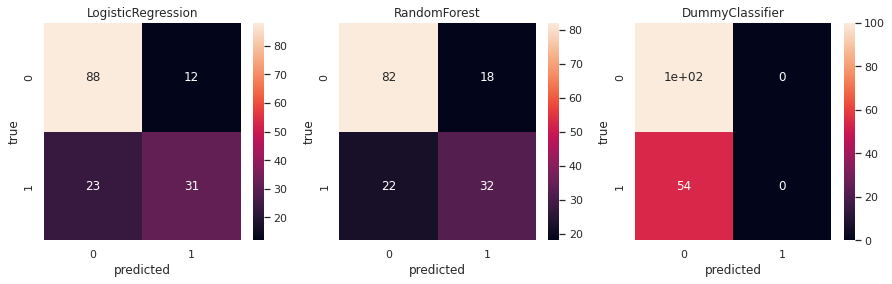

In [48]:
# Plotting confusion matrix for all classifiers
fig, axs =plt.subplots(1, 3, figsize=(15, 4))
axs = axs.flatten()

for key, ax in zip(results.keys(), axs):
    ax.set_title(key)
    sns.heatmap(results[key]['conf_mat'], annot=True, ax=ax)
    ax.set_ylabel('true')
    ax.set_xlabel('predicted')

### Discussion

- One can see that the dataset is *not balanced* with relation to each target class - number of target with value 0 (not diabetics) is ~ 3 x largen than 1 (diabetics). This unbalance will be important for the discussion of the scores in the next section.
- The confusion matrix themselves are not good tools to evaluate the performance of the classifiers. A simpler method for that is to calculate the scores, that will be discussed next.

## Scores: Accuracy, Recall, Precision, F1 scores

A good explanation about classification scores can be found [here](https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9).

- **Accuracy** is the overall rate of classes being correctly predicted. It is very sensitive to imbalances on the relative size of each class. 

- **Precision** is the fraction of predicted positives that are actually positives. It is important when the cost of false positive is high. E.g. email spam detection (we do not want to classify a real email as spam, but we do not mind classifying a spam as real one once in a while).

- **Recall** is the fraction of true positives that were actually predicted as positives. It is important when the cost of false negatives are high. E.g. fraud or sickness detection.

- **F1 Score** is given by 2 * (p x r)/ (p + r), where p is precision and r is recall. It provides a balance between precision and recall. It is better than accuracy because it balances out the sizes of the samples for both classes.

In [49]:
# Calculating scores and storing them into a DataFrame in the results dict
for clf in results.keys():
    
    results[clf]['scores_df'] = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F1'])
    
    for y_true, y_pred in zip(results[clf]['true'], results[clf]['pred']):
        acc = accuracy_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred)
        rec = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        results[clf]['scores_df'] = results[clf]['scores_df'].append(
                {'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1': f1},
                ignore_index=True
        )

In [50]:
results['LogisticRegression']['scores_df'].head()

,Accuracy,Precision,Recall,F1
0,0.772727,0.720930,0.574074,0.639175
1,0.720779,0.705882,0.562500,0.626087
2,0.792208,0.804878,0.578947,0.673469
3,0.836601,0.684211,0.666667,0.675325
4,0.764706,0.736842,0.518519,0.608696


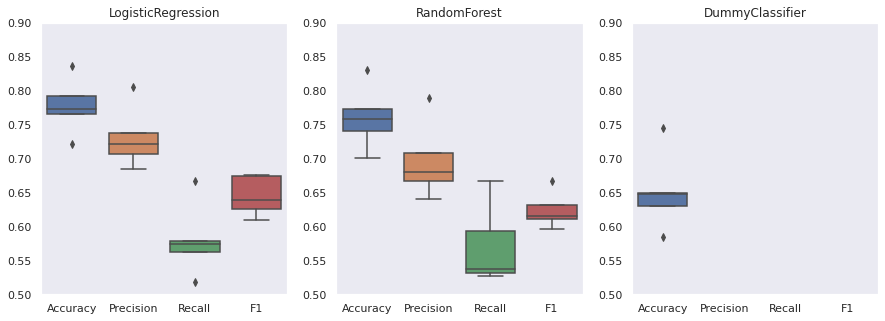

In [52]:
# Plotting the scores as box plots 
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs = axs.flatten()

for clf, ax in zip(results.keys(), axs):
    ax.set_title(clf)
    sns.boxplot(data=results[clf]['scores_df'], ax=ax)
    ax.set_ylim(0.5, 0.9)

### Discussion

First we can see that both LogisticRegression and RandomForest show a very similar trend between the scores. LogisticRegression perform slighlty better than RandomForest on average and both perform much better than the DummyClassifier (~0.75 accuracy for LR and RF against <0.65 of the DC).

Second, the accuracy is always the highest score, which is expected since it is the overall "rate of correctness" of the model. Another expected feature is that the F1 score is an intermediate value between precision and recall, which makes sense by construction.

Comparing precision and recall we see that precision is significantly higher (~0.7 against ~0.55). For this specific problem, however, our priority is to find as many diabetics as possible, even if that means we willmisclassify some non-diabetics as diabetics. Therefore we want to optimize the *fraction of true positive that were actually predicted as positive*, the **recall**. The recall in our modelling is around 0.55 - 0.6, which is not that good.

In order to evaluate whether we can reach a better recall by changing the threshold, we will plot next the recall and precision vs threshold for the Logistic Regression model.

### Opmitizing Decision Threshold

In [72]:
# Calculating recall and precision as a function of threshold
recall, precision, accuracy = list(), list(), list()
threshold = np.linspace(0, 0.99, 20)

clf = 'LogisticRegression'

for thr in threshold:
    y_true = results[clf]['true'][0]
    y_pred = [int(r > thr) for r in results[clf]['prob'][0][:,1]] 
    
    precision.append(precision_score(y_true, y_pred))
    recall.append(recall_score(y_true, y_pred))
    accuracy.append(accuracy_score(y_true, y_pred))    

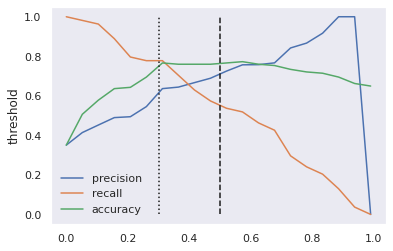

In [75]:
# Plotting recall and precision x threshold
ax = plt.gca()

ax.plot(threshold, precision, label='precision')
ax.plot(threshold, recall, label='recall')
ax.plot(threshold, accuracy, label='accuracy')

ax.set_ylabel('recall/precision')
ax.set_ylabel('threshold')

ax.plot([0.5, 0.5], [0, 1.0], color='k', linestyle='--')
ax.plot([0.3, 0.3], [0, 1.0], color='k', linestyle=':')

ax.legend();

We can see from the plot that there is a trade off between recall and precision. On an extreme case, when the threshold is set to zero, all examples are classified as positives, which leads to recall equals to 1.0. This extreme scenario is clearly not a good option since we are not making use of all the information countained in the dataset to optimize the classification. Ideally, we would like to find a optimal threshold that still maintains a certain high level of accuracy.

In our plot we can see that between 0.3 and 0.6 the accuracy reaches a plateau. This means that varying the threshold within this range will only represent a trade between recall and precision without a lossof accuracy. Therefore, **the new threshold should be set to around 0.3**, where the recall reaches a maximum before the accuracy start dropping.

## ROC curve and AUC

Explanations about ROC and AUC can be found [here](https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5).

Mean AUC
LogisticRegression 0.843
RandomForest 0.825


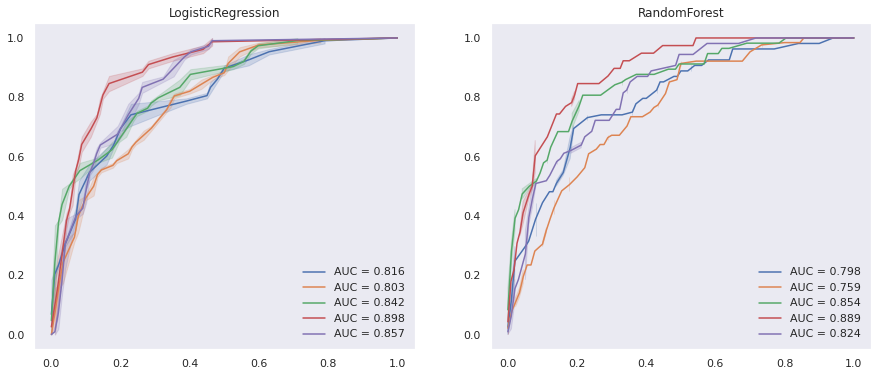

In [55]:
# Plotting ROC curves

fig, axs =plt.subplots(1, 2, figsize=(15, 6))
axs = axs.flatten()

for ax, key in zip(axs, ('LogisticRegression', 'RandomForest')):

    ax.set_title(key)
    for y_true, y_prob in zip(results[key]['true'], results[key]['prob']):
        fpr, tpr, thresholds = roc_curve(y_true, y_prob[:,1])
        auc_score = auc(fpr, tpr)
        results[key]['AUC'].append(auc_score)
        sns.lineplot(fpr, tpr, ax=ax, label='AUC = {:.3f}'.format(auc_score));

    ax.legend()

print('Mean AUC')
for key in ('LogisticRegression', 'RandomForest'):
    print('{} {:.3f}'.format(key, np.mean(results[key]['AUC'])))


- The ROC looks very similar for both models.
- The AUC is an overall metric (like accuracy) and we see that the same trend is observed, where LogisticRegrssion performs slighlty better than RandomForest.